In [1]:
import pandas as pd
from numpy import load
import matplotlib.pyplot as plt
from numpy import save
import numpy as np
import cv2
import tensorflow as tf
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from keras.utils import normalize
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [2]:
!pip install --upgrade gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!gdown 1-FuNH_VEkltxgD_6NaEtZJQR7ABtEJeu

Downloading...
From: https://drive.google.com/uc?id=1-FuNH_VEkltxgD_6NaEtZJQR7ABtEJeu
To: /content/Final_masks.npy
100% 1.18G/1.18G [00:06<00:00, 169MB/s]


In [20]:
!gdown 1-JvSo_TegFO37CKFsv7zMuCaLIlthq7u

Downloading...
From: https://drive.google.com/uc?id=1-JvSo_TegFO37CKFsv7zMuCaLIlthq7u
To: /content/Final_images1.npy
100% 1.18G/1.18G [00:15<00:00, 74.2MB/s]


In [2]:
trainX, valX, trainY, valY = train_test_split(np.expand_dims(np.load('/content/Final_images1.npy'),axis=3),np.load('/content/Final_masks.npy'), test_size=0.20, random_state=42, shuffle=False)

In [2]:
# trainX, val_test_df, trainY, val_test_class = train_test_split(
#         np.expand_dims(np.load('/content/Final_images.npy'),axis=3), np.load('/content/Final_masks.npy'), train_size=0.7, random_state=42, shuffle=False)
# valX, test_df, valY, test_class = train_test_split(
#         val_test_df, val_test_class, train_size=0.5, random_state=42)

In [3]:
masks_cat=0
masks_cat_test=0

In [4]:
trainX.shape

(7200, 128, 128, 1, 1)

In [5]:
from keras.utils import to_categorical

In [6]:
masks_cat=to_categorical(trainY, num_classes= 4)

In [7]:
masks_cat_val=to_categorical(valY[0:1000], num_classes=4)

In [8]:
masks_cat_test=to_categorical(valY[1000::], num_classes=4)

In [9]:
!pip install segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
trainY=0
valY=0

In [11]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)



################################################################
def multi_unet_model(n_classes=4, IMG_HEIGHT=128, IMG_WIDTH=128, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    model.summary()
    
    return model

In [12]:
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  #


IMG_HEIGHT = trainX.shape[1]
IMG_WIDTH  = trainX.shape[2]
IMG_CHANNELS = trainX.shape[3]



metrics=['accuracy', jacard_coef]

Segmentation Models: using `keras` framework.


In [13]:
model =  multi_unet_model(n_classes=4, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [49]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

In [46]:
!gdown 1-0k_-3CAod7Y6XpjeQk6cbF2e-RmslnJ

Downloading...
From: https://drive.google.com/uc?id=1-0k_-3CAod7Y6XpjeQk6cbF2e-RmslnJ
To: /content/my_model_150_epochs.h5
100% 7.87M/7.87M [00:00<00:00, 23.4MB/s]


In [48]:
model = tf.keras.models.load_model('/content/my_model_150_epochs.h5')

In [15]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_jacard_coef',
    min_delta=0,
    patience=17,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    
)

In [50]:
history1 = model.fit( trainX, masks_cat, 
                    batch_size = 64, 
                    
                    epochs=120, 
                    validation_data=(valX[0:1000], masks_cat_val), shuffle=False)

Epoch 1/120
113/113 [==============================] - 20s 164ms/step - loss: 0.0587 - accuracy: 0.9811 - jacard_coef: 0.9456 - val_loss: 0.0938 - val_accuracy: 0.9710 - val_jacard_coef: 0.9188
Epoch 2/120
113/113 [==============================] - 18s 159ms/step - loss: 0.0583 - accuracy: 0.9805 - jacard_coef: 0.9439 - val_loss: 0.1007 - val_accuracy: 0.9677 - val_jacard_coef: 0.9156
Epoch 3/120
113/113 [==============================] - 18s 160ms/step - loss: 0.0498 - accuracy: 0.9831 - jacard_coef: 0.9508 - val_loss: 0.0892 - val_accuracy: 0.9696 - val_jacard_coef: 0.9205
Epoch 4/120
113/113 [==============================] - 18s 160ms/step - loss: 0.0455 - accuracy: 0.9843 - jacard_coef: 0.9545 - val_loss: 0.0890 - val_accuracy: 0.9695 - val_jacard_coef: 0.9200
Epoch 5/120
113/113 [==============================] - 18s 161ms/step - loss: 0.0427 - accuracy: 0.9852 - jacard_coef: 0.9570 - val_loss: 0.0827 - val_accuracy: 0.9725 - val_jacard_coef: 0.9277
Epoch 6/120
113/113 [=========

KeyboardInterrupt: ignored

In [19]:
hist_df1 = pd.DataFrame(history1.history)
hist_df1.to_csv('history1.csv')
hist_df1

,loss,accuracy,jacard_coef,val_loss,val_accuracy,val_jacard_coef
0,0.173408,0.941431,0.866594,0.050217,0.973725,0.941386
1,0.044530,0.977508,0.950571,0.035800,0.979486,0.957101
2,0.037474,0.982013,0.957750,0.026089,0.985798,0.967059
3,0.025000,0.989134,0.970074,0.020392,0.989512,0.974533
4,0.012999,0.994967,0.983754,0.003948,0.998674,0.994233
5,0.007055,0.997427,0.991516,0.002358,0.999187,0.996560
6,0.005433,0.997986,0.993523,0.001523,0.999537,0.997699
7,0.004459,0.998339,0.994706,0.001335,0.999612,0.998031
8,0.003742,0.998614,0.995574,0.001202,0.999629,0.998307
9,0.003213,0.998813,0.996190,0.001149,0.999619,0.998471


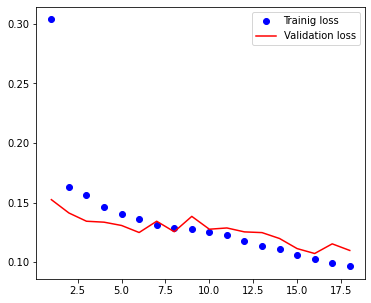

In [17]:
loss = history1.history['loss']
val_loss = history1.history['val_loss']

# iou_coef = history.history['iou_coef']
# val_iou_coef = history.history['val_iou_coef']

# dice_coef = history.history['dice_coef']
# val_dice_coef = history.history['val_dice_coef']


epochs = range(1, len(loss) + 1)

plt.figure(figsize=(20, 5))

# loss
plt.subplot(1,3,1)
plt.plot(epochs, loss, 'bo', label = 'Trainig loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.legend()


# dice
# plt.subplot(1,3,2)
# plt.plot(epochs, dice_coef, 'bo', label = 'Training dice accuracy')
# plt.plot(epochs, val_dice_coef, 'r', label = 'Validation dice accuracy')
# plt.legend()

plt.show()

In [26]:
test_img_number = 1000

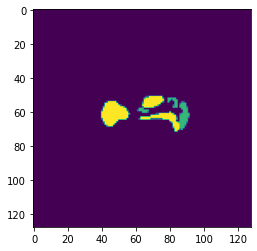

In [30]:
plt.imshow(valX[0][:,:,0])

In [60]:
model.evaluate(valX[1000::],masks_cat_test)

25/25 [==============================] - 1s 30ms/step - loss: 0.1082 - accuracy: 0.9725 - jacard_coef: 0.9375


[0.1081795021891594, 0.9724843502044678, 0.9375149011611938]

1/1 [==============================] - 0s 17ms/step


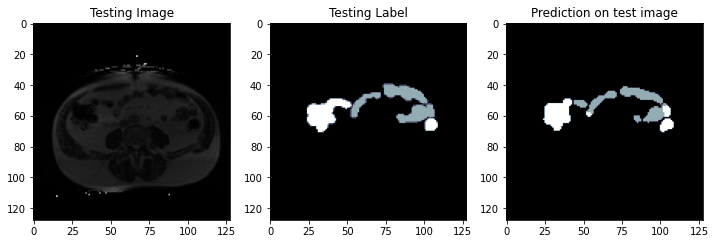

In [58]:
import random

# test_img_number = 0
test_img = valX[1000+50]
ground_truth=valX[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(np.argmax(masks_cat_test[50], axis=2), cmap='bone')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='bone')
plt.show()
test_img_number+=1